In [23]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import sklearn

In [21]:
data = pd.read_csv('zzc_ail.csv')
data['date'] = data['date'].str.replace('"', '').astype(float)
data['open'] = data['open'].str.replace('"', '').astype(float)
data['high'] = data['high'].str.replace('"', '').astype(float)
data['low'] = data['low'].str.replace('"', '').astype(float)
data['close'] = data['close'].str.replace('"', '').astype(float)

In [3]:
dates = tf.constant(data['date'], dtype=tf.float64)
open_prices = tf.constant(data['open'], dtype=tf.float64)
high_prices = tf.constant(data['high'], dtype=tf.float64)
low_prices = tf.constant(data['low'], dtype=tf.float64)
close_prices = tf.constant(data['close'], dtype=tf.float64)

2024-04-29 18:02:42.206664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


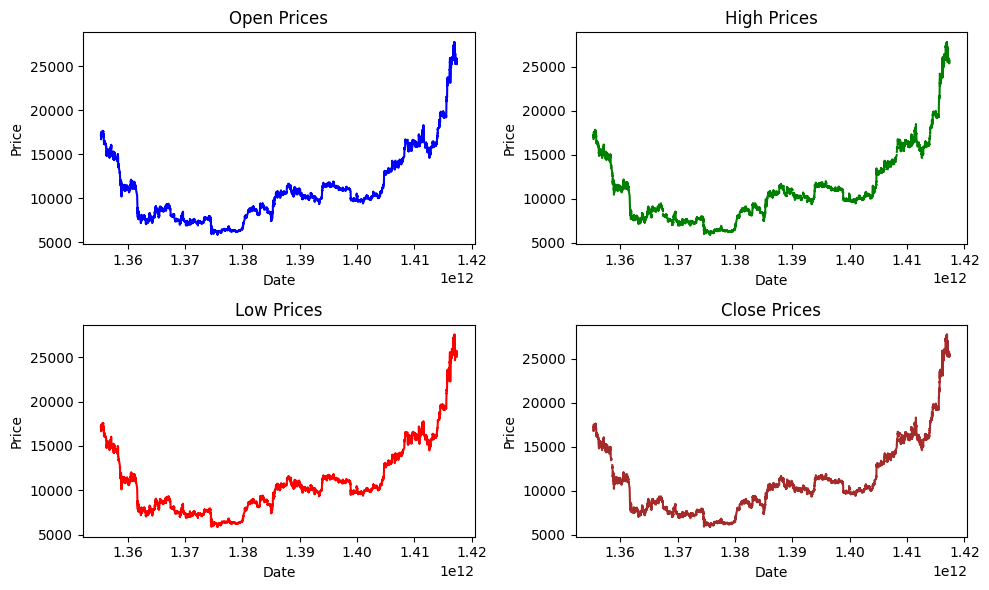

In [5]:
plt.figure(figsize=(10, 6))

# Open Prices
plt.subplot(2, 2, 1)
plt.plot(dates, open_prices, color='blue')
plt.title('Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# High Prices
plt.subplot(2, 2, 2)
plt.plot(dates, high_prices, color='green')
plt.title('High Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Low Prices
plt.subplot(2, 2, 3)
plt.plot(dates, low_prices, color='red')
plt.title('Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Close Prices
plt.subplot(2, 2, 4)
plt.plot(dates, close_prices, color='brown')
plt.title('Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

In [7]:
data.interpolate(method='linear', inplace=True) # IMPUTATION 

In [9]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 date     0
open     0
high     0
low      0
close    0
dtype: int64


In [46]:
dataset_ex_df = data.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['date'] = pd.to_datetime(dataset_ex_df['date'])
dataset_ex_df.set_index('date', inplace=True)
dataset_ex_df = dataset_ex_df['high'].to_frame()

In [11]:


# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['high'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.59 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=138765.744, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=136208.244, Time=0.73 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=138763.744, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=135062.285, Time=0.95 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=134310.453, Time=1.14 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=133835.362, Time=1.81 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=133401.764, Time=2.38 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=17.74 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.94 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=133399.764, Time=0.71 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=133833.362, Time=0.54 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=5.94 sec
 ARIMA(4,2,1)(0,0,0)[0]             : 

In [51]:


# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(5,2,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9211,) + inhomogeneous part.

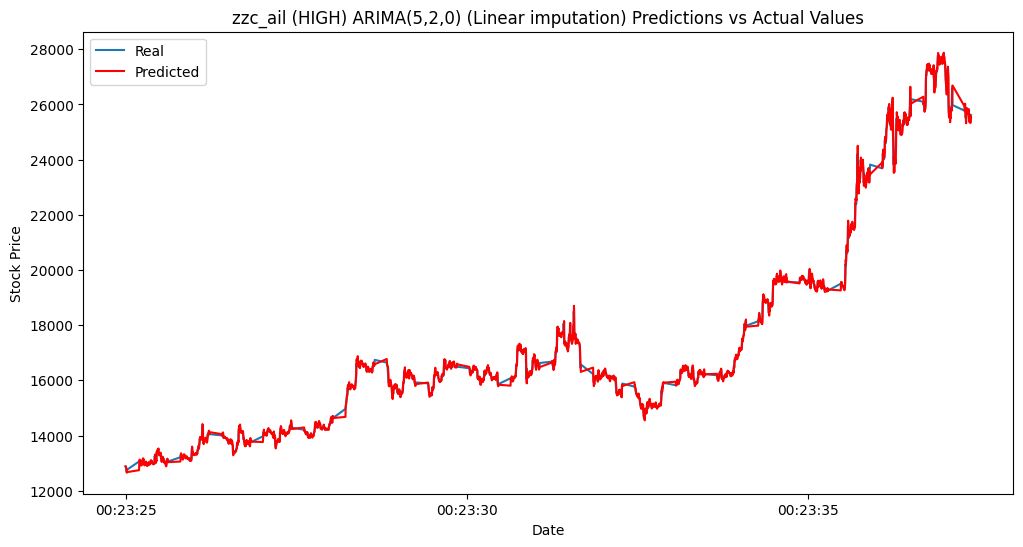

In [31]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('zzc_ail (HIGH) ARIMA(5,2,0) (Linear imputation) Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [30]:
# sklearn.metrics.mean_squared_log_error(test,predictions)  MSLE -> yarışmada kullanılan
sklearn.metrics.r2_score(test,predictions)

0.9990073225110856

In [41]:
train = dataset_ex_df.values  # TRAIN DATANIN HEPSINI VERIP BIR SONRAKI 201 GÜNÜ ALMAK İÇİN:


# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(100):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

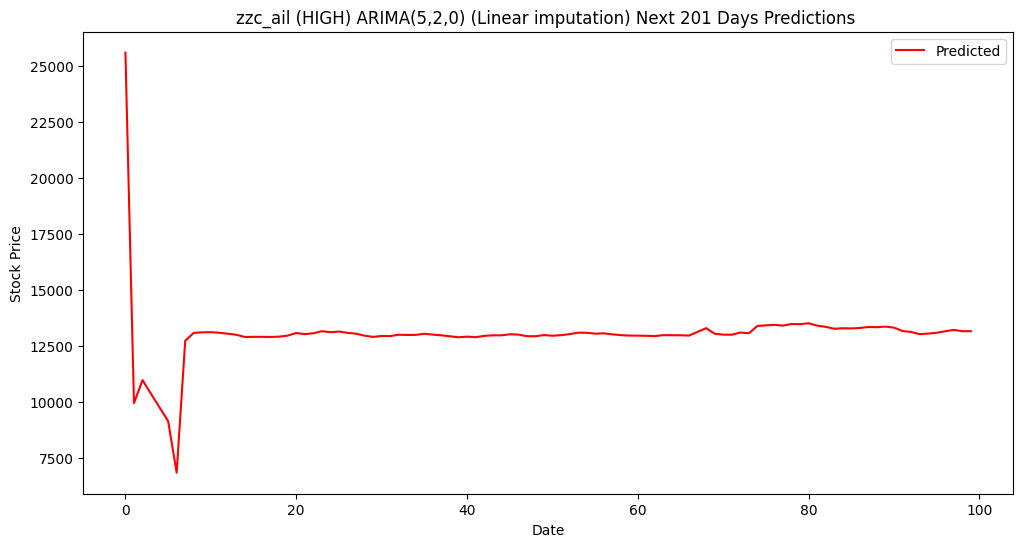

In [43]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(range(100), predictions, color='red', label='Predicted')
plt.title('zzc_ail (HIGH) ARIMA(5,2,0) (Linear imputation) Next 201 Days Predictions ')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

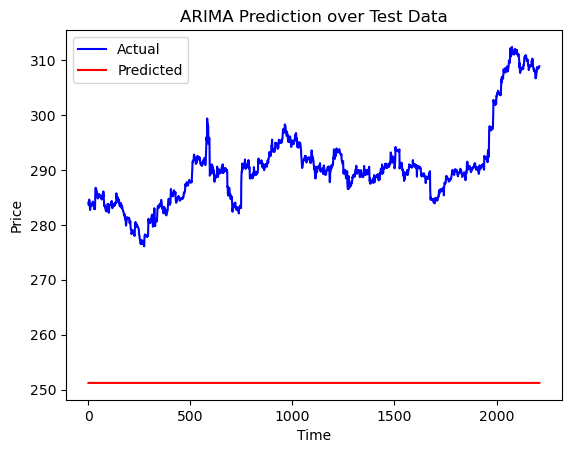

In [126]:
"""import matplotlib.pyplot as plt

# Generate time indices for the test data
time_indices = range(len(test_data))

# Plot actual test data
plt.plot(time_indices, test_data, label='Actual', color='blue')

# Plot predicted values over the same time indices
plt.plot(time_indices, forecast_test, label='Predicted', color='red')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ARIMA Prediction over Test Data')
plt.legend()

# Show plot
plt.show()"""